# Mistral image analysis in Azure AI Foundry

In [1]:
import base64
import IPython.display as Disp
import os
import requests
import sys

from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import AssistantMessage, UserMessage, SystemMessage, TextContentItem, ImageContentItem, ImageUrl
from azure.core.credentials import AzureKeyCredential
from azure.core.exceptions import HttpResponseError
from datetime import datetime
from dotenv import load_dotenv
from mistralai_azure import MistralAzure
from PIL import Image
from urllib.request import urlopen, Request

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 18-Apr-2025 09:18:52


## Settings

In [4]:
load_dotenv("azure.env")

endpoint = os.getenv("endpoint")
key = os.getenv("key")

In [5]:
model = "mistral-small-2503"

"mistral-small-2503"
- Input: text and images (131,072 tokens),
image-based tokens are 16px x 16px
blocks of the original images
- Output: text (4,096 tokens)
- Tool calling: Yes
- Response formats: Text, JSON

## Quick test

In [6]:
mistralazureclient = MistralAzure(azure_endpoint=endpoint, azure_api_key=key)

In [7]:
messages = [
    {
        "role": "user",
        "content": "What is the best French meal? Return the name and the ingredients in short JSON object.",
    }
]
chat_response = mistralazureclient.chat.complete(
      model = model,
      messages = messages,
      response_format = {
          "type": "json_object",
      }
)

print(chat_response)

id='e9dafda25b6642b0bd36c72c657267d6' object='chat.completion' model='mistral-small-2503' usage=UsageInfo(prompt_tokens=21, completion_tokens=91, total_tokens=112) created=1744967934 choices=[ChatCompletionChoice(index=0, message=AssistantMessage(content='[{\n  "name": "Coq au Vin",\n  "ingredients": [\n    "Chicken",\n    "Red Wine",\n    "Bacon",\n    "Onions",\n    "Carrots",\n    "Mushrooms",\n    "Garlic",\n    "Tomato Paste",\n    "Chicken Stock",\n    "Bay Leaves",\n    "Thyme",\n    "Butter",\n    "Flour"\n  ]\n} ]', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


In [8]:
print(chat_response.choices[0].message.content)

[{
  "name": "Coq au Vin",
  "ingredients": [
    "Chicken",
    "Red Wine",
    "Bacon",
    "Onions",
    "Carrots",
    "Mushrooms",
    "Garlic",
    "Tomato Paste",
    "Chicken Stock",
    "Bay Leaves",
    "Thyme",
    "Butter",
    "Flour"
  ]
} ]


## Helper

In [9]:
def mistral(prompt: str) -> str:
    """
    Sends a prompt to the Mistral model using MistralAzure and returns the model's response.

    Args:
        prompt (str): The input text to be processed by the AI model.

    Returns:
        str: The generated response from the Mistral model. Returns an error message if the request fails.
    """
    try:
        mistralazureclient = MistralAzure(azure_endpoint=endpoint, azure_api_key=key)

        response = mistralazureclient.chat.complete(
            messages=[{
                "role": "user",
                "content": prompt
            }],
            model=model,
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"Error calling Mistral model: {e}")
        return "An error occurred while generating a response."

In [10]:
prompt = "Hello"

mistral(prompt)

"Hello! How can I assist you today? Let me know if you have any questions or if there's a topic you'd like to discuss. I'm here to help! 😊"

In [11]:
prompt = "What is the capital of France?"

mistral(prompt)

'The capital of France is **Paris**. Paris is known for its rich history, iconic landmarks such as the Eiffel Tower, Louvre Museum, and Notre-Dame Cathedral, as well as its cultural and artistic contributions. It is also a major global center for art, fashion, gastronomy, and culture.'

## Using an url image

In [12]:
image_url = "https://news.microsoft.com/source/wp-content/uploads/2024/04/The-Phi-3-small-language-models-with-big-potential-1-1900x1069.jpg"
image_format = "jpeg"

request = Request(image_url, headers={"User-Agent": "Mozilla/5.0"})
image_data = base64.b64encode(urlopen(request).read()).decode("utf-8")
data_url = f"data:image/{image_format};base64,{image_data}"

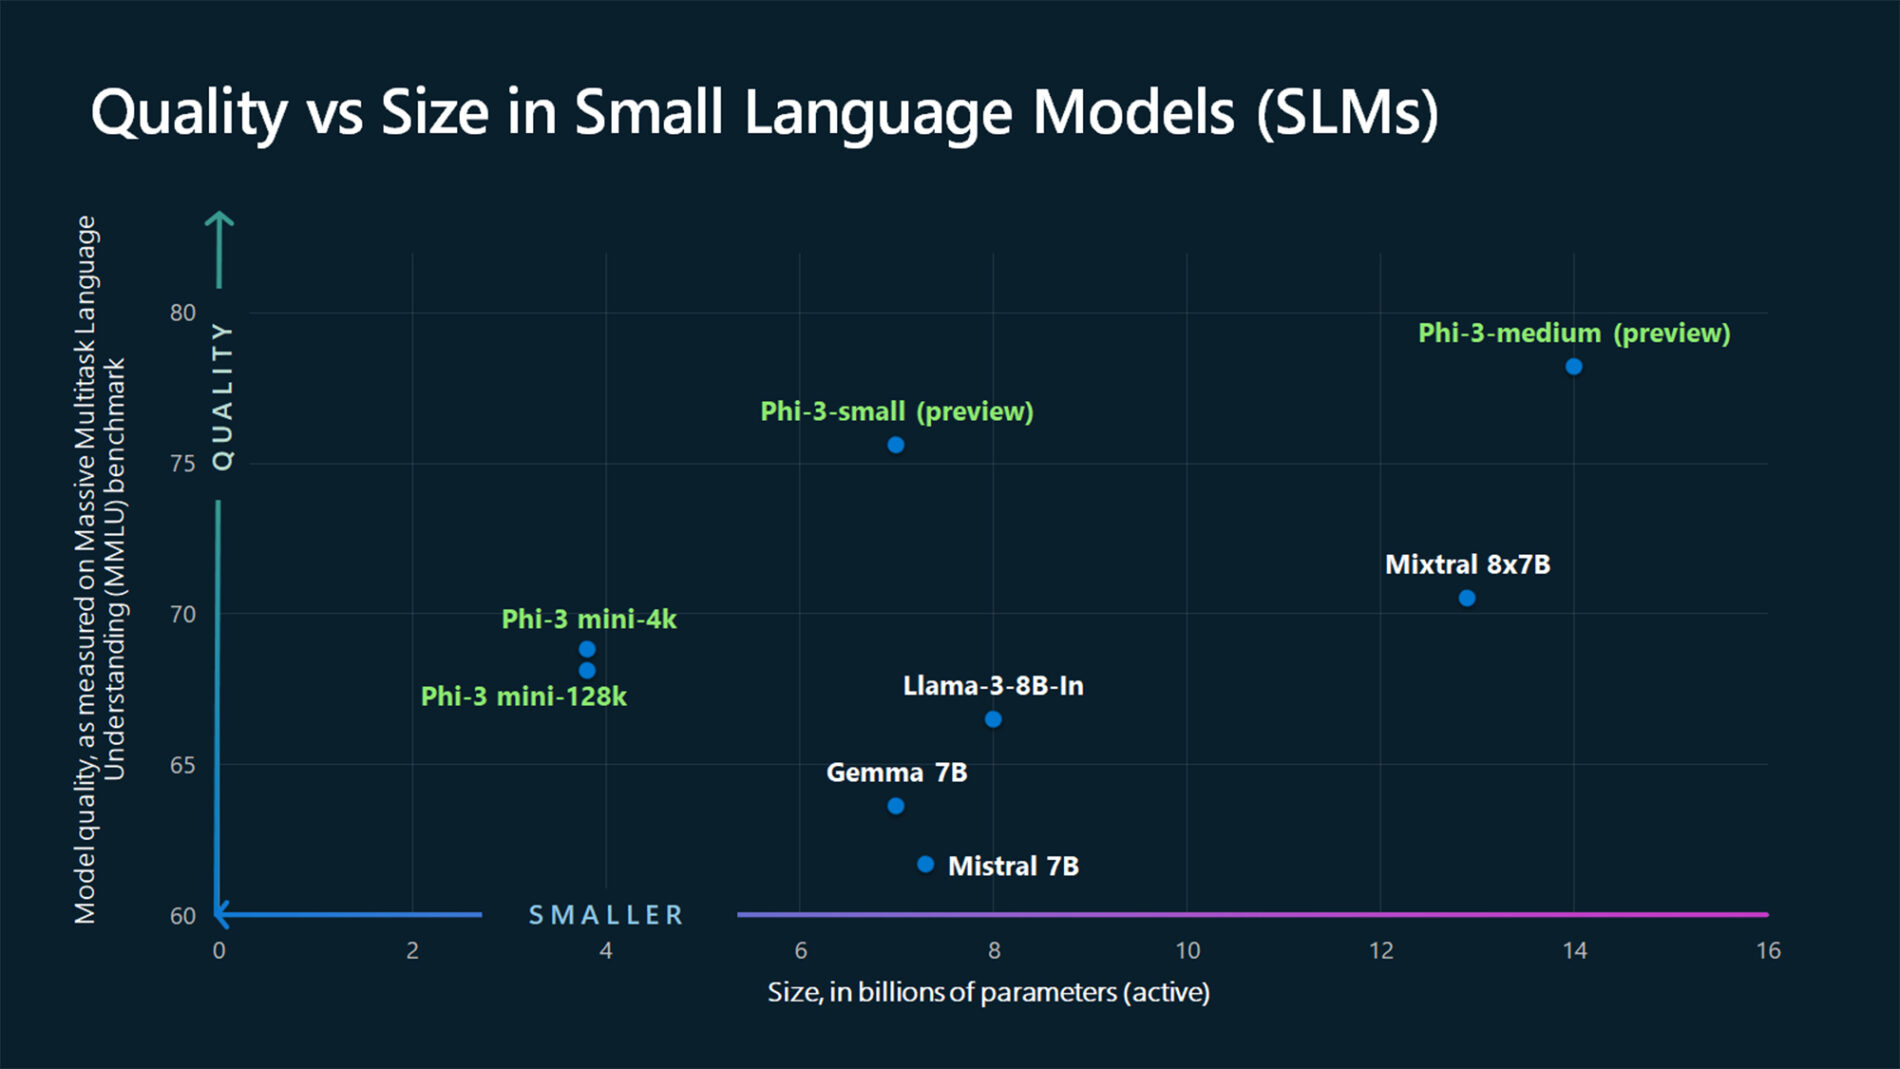

In [13]:
Disp.Image(requests.get(image_url).content)

In [14]:
client = ChatCompletionsClient(endpoint=endpoint,
                               credential=AzureKeyCredential(key),
                               model=model)

In [15]:
response = client.complete(
    messages=[
        SystemMessage(
            "You are a helpful assistant that can generate responses based on images."
        ),
        UserMessage(content=[
            TextContentItem(
                text=
                "Which conclusion can be extracted from the following chart?"),
            ImageContentItem(image_url=ImageUrl(url=data_url))
        ]),
    ],
    temperature=1,
    max_tokens=2048,
)

In [16]:
print("\033[1;31;34m")
print(response)


{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "The chart titled \"Quality vs Size in Small Language Models (SLMs)\" provides a comparison of different language models based on their quality and size. Here are the key conclusions that can be drawn from the chart:\n\n1. **Quality vs. Size Relationship**:\n   - Generally, larger models (with more parameters) tend to have higher quality scores. This is evident as models like \"Phi-3-medium (preview)\" and \"Mixtral 8x7B\" are positioned higher on the quality axis and further to the right on the size axis.\n   - Smaller models tend to have lower quality scores. For example, \"Phi-3 mini-4k\" and \"Phi-3 mini-128k\" are positioned lower on the quality axis and closer to the left on the size axis.\n\n2. **Performance of Specific Models**:\n   - \"Phi-3-medium (preview)\" stands out as having one of the highest quality scores among the models compared, despite not being the large

In [17]:
print("\033[1;31;34m")
print(f"{response.choices[0].message.role}: {response.choices[0].message.content}")


assistant: The chart titled "Quality vs Size in Small Language Models (SLMs)" provides a comparison of different language models based on their quality and size. Here are the key conclusions that can be drawn from the chart:

1. **Quality vs. Size Relationship**:
   - Generally, larger models (with more parameters) tend to have higher quality scores. This is evident as models like "Phi-3-medium (preview)" and "Mixtral 8x7B" are positioned higher on the quality axis and further to the right on the size axis.
   - Smaller models tend to have lower quality scores. For example, "Phi-3 mini-4k" and "Phi-3 mini-128k" are positioned lower on the quality axis and closer to the left on the size axis.

2. **Performance of Specific Models**:
   - "Phi-3-medium (preview)" stands out as having one of the highest quality scores among the models compared, despite not being the largest in terms of parameters.
   - "Mixtral 8x7B" is one of the largest models in terms of parameters and also has a high 

In [18]:
print("Model:", response.model)

Model: mistral-small-2503


In [19]:
print(f"Prompt = {response.usage.prompt_tokens} tokens")
print(f"Completion = {response.usage.completion_tokens} tokens")
print(f"Total = {response.usage.total_tokens} tokens")

Prompt = 826 tokens
Completion = 465 tokens
Total = 1291 tokens


### Using local images

In [20]:
image_path = 'id.jpg'

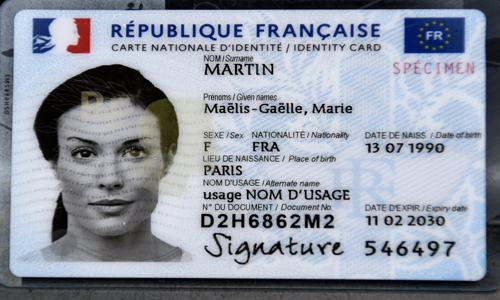

In [21]:
img = Image.open(image_path)

image_resized = img.resize((500, 300))
image_resized

In [22]:
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()

image_base64 = base64.b64encode(image_data).decode('utf-8')
image_content_item = ImageContentItem(image_url=ImageUrl(url=f'data:image/jpeg;base64,{image_base64}'))

response = client.complete(
    messages=[
        SystemMessage(
            "You are a helpful assistant that can generate responses based on images."
        ),
        UserMessage(content=[
            TextContentItem(
                text="Describe this image"),
            image_content_item
        ]),
    ],
    temperature=1,
    max_tokens=2048,
)

print("\033[1;31;34m")
print(response)


{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "This image is of a French national identity card, known as a \"Carte Nationale d'Identit\u00e9.\" The card includes the following details:\n\n1. **Header Information:**\n   - \"R\u00c9PUBLIQUE FRAN\u00c7AISE\" indicating it is a French document.\n   - \"CARTE NATIONALE D'IDENTIT\u00c9 / IDENTITY CARD\" specifying the type of document.\n\n2. **Personal Information:**\n   - **Nom / Surname:** Martin\n   - **Pr\u00e9noms / Given Names:** Ma\u00eblis-Ga\u00eblle, Marie\n   - **Sexe / Sex:** F (Femme / Female)\n   - **Nationalit\u00e9 / Nationality:** FRA (France)\n   - **Date de Naiss. / Date of Birth:** 13 July 1990\n   - **Lieu de Naissance / Place of Birth:** Paris\n   - **Nom d'Usage / Alternate Name:** usage NOM D'USAGE\n\n3. **Document Details:**\n   - **N\u00b0 du Document / Document No.:** D2H6862M2\n   - **Date d'Expir. / Expiry Date:** 11 February 2030\n   - **Signature

In [23]:
print("\033[1;31;34m")
print(f"{response.choices[0].message.role}: {response.choices[0].message.content}")


assistant: This image is of a French national identity card, known as a "Carte Nationale d'Identité." The card includes the following details:

1. **Header Information:**
   - "RÉPUBLIQUE FRANÇAISE" indicating it is a French document.
   - "CARTE NATIONALE D'IDENTITÉ / IDENTITY CARD" specifying the type of document.

2. **Personal Information:**
   - **Nom / Surname:** Martin
   - **Prénoms / Given Names:** Maëlis-Gaëlle, Marie
   - **Sexe / Sex:** F (Femme / Female)
   - **Nationalité / Nationality:** FRA (France)
   - **Date de Naiss. / Date of Birth:** 13 July 1990
   - **Lieu de Naissance / Place of Birth:** Paris
   - **Nom d'Usage / Alternate Name:** usage NOM D'USAGE

3. **Document Details:**
   - **N° du Document / Document No.:** D2H6862M2
   - **Date d'Expir. / Expiry Date:** 11 February 2030
   - **Signature:** A sample signature is present.
   - **ID Number:** 546497

4. **Additional Information:**
   - The word "SPÉCIMEN" in red indicates that this is a sample or specimen

In [24]:
print(f"Prompt = {response.usage.prompt_tokens} tokens")
print(f"Completion = {response.usage.completion_tokens} tokens")
print(f"Total = {response.usage.total_tokens} tokens")

Prompt = 972 tokens
Completion = 344 tokens
Total = 1316 tokens


## Another example

In [25]:
image_path = 'image.jpg'

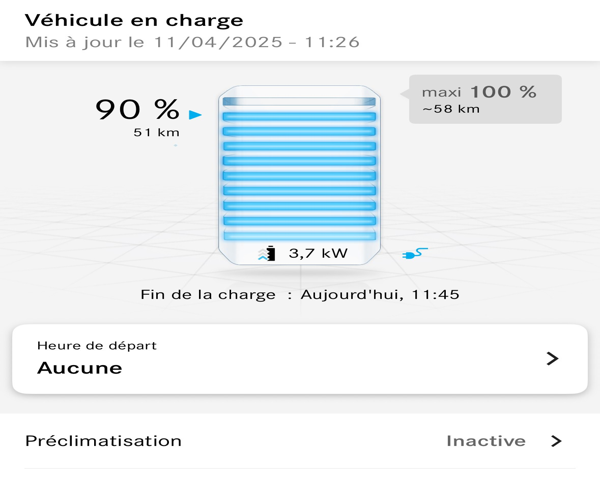

In [26]:
img = Image.open(image_path)

image_resized = img.resize((600, 500))
image_resized

In [27]:
with open(image_path, 'rb') as image_file:
    image_data = image_file.read()

image_base64 = base64.b64encode(image_data).decode('utf-8')
image_content_item = ImageContentItem(image_url=ImageUrl(url=f'data:image/jpeg;base64,{image_base64}'))

response = client.complete(
    messages=[
        SystemMessage(
            "You are a helpful assistant that can generate responses based on images."
        ),
        UserMessage(content=[
            TextContentItem(
                text="Describe this image"),
            image_content_item
        ]),
    ],
    temperature=1,
    max_tokens=2048,
)

print("\033[1;31;34m")
print(response)


{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "This image is a screenshot from a mobile application showing the charging status of an electric vehicle. Here is a detailed summary of the information presented:\n\n1. **Title**: \"V\u00e9hicule en charge\" (Vehicle Charging)\n2. **Last Updated**: The status was last updated on April 11, 2025, at 11:26 AM.\n3. **Battery Status**: \n   - The battery is at 90% charge.\n   - The vehicle can currently travel approximately 51 kilometers (km) with the current charge.\n   - The maximum battery capacity is 100%, which corresponds to approximately 58 km of range.\n4. **Charging Information**: \n   - The vehicle is charging at a rate of 3.7 kW.\n   - The charging is expected to finish on the same day at 11:45 AM.\n5. **Departure Time**: \n   - No departure time has been set (\"Heure de d\u00e9part: Aucune\").\n6. **Preconditioning (Pr\u00e9climatisation)**: \n   - The preconditioning f

In [28]:
print("\033[1;31;34m")
print(f"{response.choices[0].message.role}: {response.choices[0].message.content}")


assistant: This image is a screenshot from a mobile application showing the charging status of an electric vehicle. Here is a detailed summary of the information presented:

1. **Title**: "Véhicule en charge" (Vehicle Charging)
2. **Last Updated**: The status was last updated on April 11, 2025, at 11:26 AM.
3. **Battery Status**: 
   - The battery is at 90% charge.
   - The vehicle can currently travel approximately 51 kilometers (km) with the current charge.
   - The maximum battery capacity is 100%, which corresponds to approximately 58 km of range.
4. **Charging Information**: 
   - The vehicle is charging at a rate of 3.7 kW.
   - The charging is expected to finish on the same day at 11:45 AM.
5. **Departure Time**: 
   - No departure time has been set ("Heure de départ: Aucune").
6. **Preconditioning (Préclimatisation)**: 
   - The preconditioning feature is currently inactive.

The image provides a clear and concise overview of the electric vehicle's charging status, expected co